<a href="https://colab.research.google.com/github/MDankloff/ClusterCompas/blob/main/COMPAS_Clustering_DBSCAN_clean_utils.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries and Data

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")
import os
import random
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.manifold import TSNE

In [16]:
Shap_error_data = pd.read_csv('/content/Shap_error_data.csv')
Shap_error_data.info()
## features = Shap_error_data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP',
##                                 'Shap_age', 'Shap_priors_count' , 'Shap_sex_Female', 'Shap_sex_Male', 'Shap_race_African-American', 'Shap_race_Asian', 'Shap_race_Caucasian', 'Shap_race_Hispanic', 'Shap_race_Native American', 'Shap_race_Other'
##                                 ], axis=1)

#print(Shap_error_data.loc[3])
#print(Shap_error_data.isna().sum())
len(Shap_error_data.index)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         5050 non-null   float64
 1   priors_count                5050 non-null   float64
 2   sex_Female                  5050 non-null   float64
 3   sex_Male                    5050 non-null   float64
 4   race_African-American       5050 non-null   float64
 5   race_Asian                  5050 non-null   float64
 6   race_Caucasian              5050 non-null   float64
 7   race_Hispanic               5050 non-null   float64
 8   race_Native American        5050 non-null   float64
 9   race_Other                  5050 non-null   float64
 10  Shap_age                    5050 non-null   float64
 11  Shap_priors_count           5050 non-null   float64
 12  Shap_sex_Female             5050 non-null   float64
 13  Shap_sex_Male               5050 

5050

In [17]:
display(len(Shap_error_data.loc[Shap_error_data['FP']==1]))
display(len(Shap_error_data.loc[Shap_error_data['FN']==1]))

648

750

# Utils for Data Preparation

In [160]:
META_COL = ['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'clusters', 'new_clusters']
SHAP_COL = ['Shap_age', 'Shap_priors_count' , 'Shap_sex_Female', 'Shap_sex_Male',
            'Shap_race_African-American', 'Shap_race_Asian', 'Shap_race_Caucasian', 'Shap_race_Hispanic',
            'Shap_race_Native American', 'Shap_race_Other']

In [161]:
# Scale features, but not "meta column"
def scale_data(data_fixed, meta_col = META_COL):
    data = data_fixed.copy(deep=True)
    features = data.drop(meta_col, axis=1)
    to_scale = data.drop(meta_col, axis=1).columns
    data[to_scale] = StandardScaler().fit_transform(features[to_scale])
    for col in meta_col:
            data[col] = data_fixed[col]
    return data

# Keep only rows with the type of errors to target (e.g., TP & FN, or TN & FP, ...)
def filter_error_rows(data, error_col='TP', correct_col='FN'):
  return data.loc[(data[error_col] == 1) | (data[correct_col] == 1)]

# Drop "meta columns" not containing data features or SHAP features
def drop_meta_col(data, meta_col = META_COL):
  return data.drop(meta_col, axis=1)

def drop_shap_col(data, shap_col = SHAP_COL):
  return data.drop(shap_col, axis=1)

# Initialise clustering dataset, with added columns for cluster IDs, and a deep copy for future changes of the cluster IDs
def init_cluster_col(data):
    data['clusters'] = 0
    data['new_clusters'] = -1
    return data

def get_error_type(data):
    data['error_type'] = ''
    for d in data.intertuples():
      if d['TP'] == 1:
        d['error_type'] = 'TP'
      elif d['FP'] == 1:
        d['error_type'] = 'FP'
      elif d['TN'] == 1:
        d['error_type'] = 'TN'
      elif d['FN'] == 1:
        d['error_type'] = 'FN'
    return data

def basic_data_prep(data_fixed, error_col='', correct_col='', shap=False):
  data = data_fixed.copy(deep=True)
  data = init_cluster_col(data)
  if not shap:
    data = drop_shap_col(data)
  if error_col != '' and correct_col != '':
    data = filter_error_rows(data, error_col, correct_col)
  data = scale_data(data)
  return data

# Utils for Error Rate Calculation

In [20]:
# Calculate error rate, replacing accuracy_error()
def get_error_rate(results):
  if len(results) == 0:
    print ("you are calculating the error rate of an empty cluster")
  correct = results.loc[results['errors'] == 1]
  error_rate = len(correct)/ len(results)
  return error_rate

# Calculate bias in terms of error difference
# bias_type can be:
#   - 'negative' i.e., negative discrimination, when the target_cluster has more error than other cluster
#   - 'positive' i.e., positive discrimination, when the target_cluster has less error than other cluster
#   - 'absolute' the target_cluster can have either more or less error than other cluster
# baseline can be:
#   - 'other' i.e., clusters other than the target_cluster
#   - 'all' i.e., all clusters including the target_cluster
#   - 'best' i.e., the cluster with the smallest error rate
def get_error_diff(data, cluster_id, cluster_col, bias_type='negative', baseline='other', full_info=False):
  cluster_x = data.loc[data[cluster_col] == cluster_id]
  if len(cluster_x) == 0:
    print("this is an empty cluster", cluster_id)
    return

  if baseline == 'other':
    remaining_clusters = data.loc[data[cluster_col] != cluster_id]
    if len(remaining_clusters) == 0:
      print ("This cluster is the entire dataset. Cluster:", cluster_id)
      return
    error_diff = get_error_rate(cluster_x) - get_error_rate(remaining_clusters)

  if baseline == 'all':
    error_diff = get_error_rate(cluster_x) - get_error_rate(data)

  if baseline == 'best':
    best_cluster = get_cluster_w_min_bias(data, cluster_col, bias_type, baseline)
    error_diff = get_error_rate(cluster_x) - best_cluster[1]

  if full_info:
    return [error_diff, get_error_rate(cluster_x), get_error_rate(remaining_clusters)]

  if bias_type == 'positive':
    error_diff = -error_diff
  if bias_type == 'absolute':
    error_diff = np.absolute(error_diff)
  return error_diff

# Utils for Clustering

In [21]:
# Get the cluster with the maximum error difference
def get_cluster_w_max_bias(data, cluster_col='clusters', bias_type='negative', baseline='other'):
  max_bias = 0
  max_bias_cluster = -2
  full_info = [0,0,0]
  for cluster_id in data[cluster_col].unique():
    if cluster_id == -1: # outliers in dbscan
      continue
    current_bias = get_error_diff(data, cluster_id, cluster_col, bias_type, baseline) #pos function to find the highest bias
    if current_bias > max_bias:
      max_bias = current_bias
      max_bias_cluster = cluster_id

  full_info = get_error_diff(data, cluster_id, cluster_col, bias_type, baseline, full_info=True)
  print ('Cluster ID', max_bias_cluster, 'has the largest ', bias_type,' bias, compared to ', baseline,
         'cluster(s):\n   ', np.round(full_info[0],4), '(',np.round(full_info[1],4), ' Vs ', np.round(full_info[2],4), ')')
  return [max_bias_cluster, max_bias]

# Get the cluster with the minimum error difference
def get_cluster_w_min_bias(data, cluster_col='clusters', bias_type='negative', baseline='all'):
  min_bias = 1
  min_bias_cluster = -2
  full_info = [0,0,0]
  for cluster_id in data[cluster_col].unique():
    if cluster_id == -1: # outliers in dbscan
      continue
    current_bias = get_error_diff(data, cluster_id, cluster_col, bias_type, baseline)
    if current_bias < min_bias:
      min_bias = current_bias
      min_bias_cluster = cluster_id

  full_info = get_error_diff(data, cluster_id, cluster_col, bias_type, baseline, full_info=True)
  print ('Cluster ID', min_bias_cluster, 'has the smallest ', bias_type,' bias, compared to ', baseline,
         'cluster(s):\n   ', np.round(full_info[0],4), '(',np.round(full_info[1],4), ' Vs ', np.round(full_info[2],4), ')')
  return [min_bias_cluster, min_bias]

#Get the size of the smallest cluster
def get_min_cluster_size(data, cluster_col='new_clusters'):
  min_cluster_size = len(data)
  for i in data[cluster_col].unique():
    if i == -1: # Outliers in DB Scan
      continue
    size = len(data.loc[data[cluster_col]==i])
    if size < min_cluster_size:
      min_cluster_size = size
  return min_cluster_size

# Select a random cluster from a list of clusters,
# Avoiding the cluster ID -1 (outliers in dbscan)
def get_random_cluster(clusters):
  result = -1
  while (result == -1):
    result = random.randint(0, len(clusters.unique()))
  print('This is the random cluster we picked:', result)
  return result


# Plot functions

In [190]:
# PCA Plot clusters
def pca_plot(data, title, alpha=0.3, hue='clusters', s=2):
    # Exctract features for PCA and drop certain columns
    pca_features = drop_meta_col(data)

    # Apply PCA with 2 components to scaled features and create a df for the resulting principal components
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(pca_features)
    pca_df = pd.DataFrame(pca_result, index=pca_features.index, columns=['Principal Component 1', 'Principal Component 2'])

    # Create temporary dataset that contains both principal components and other features
    temp_data = pca_df.join(data[META_COL], how='left')

    # Create scatterplot using seaborn
    scatterplot = sns.scatterplot(data=temp_data, x='Principal Component 1', y='Principal Component 2',
                                  alpha=alpha, hue=hue, palette='tab10', style='Error_Type', s=s)
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    explained_variance_ratio = pca.explained_variance_ratio_
    print(f"Explained Variance Ratio: PC1 = {explained_variance_ratio[0]:.2f}, PC2 = {explained_variance_ratio[1]:.2f}")

    plt.show()

#Plot cluster
def plot_clusters(data):
  scatterplot = sns.scatterplot(data=data, x='1st', y='2nd', hue="clusters", size = 'errors', sizes=(100, 20), palette = "tab10")
  plt.show()

##########################################

def tsne_plot(data, title, perplexity = 30, learning_rate = 200, n_iter = 1000, alpha = 0.5):
    tsne_features = drop_meta_col(data)

    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
    tsne_result = tsne.fit_transform(tsne_features)
    tsne_df = pd.DataFrame(tsne_result, index = features.index, columns=['t-SNE Component 1', 't-SNE Component 2'])

    temp_dataset = tsne_df.join(data[META_COL], how='left')

    # Create scatterplot using seaborn
    scatterplot = sns.scatterplot(data=temp_dataset, x='t-SNE Component 1', y='t-SNE Component 2', alpha=alpha, hue="clusters", palette='tab10', style='Error_Type')
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    plt.show()

# Prepare and Split Datasets

In [189]:
data = pd.read_csv('/content/Shap_error_data.csv')
data = data.dropna()
# data.info()

In [162]:
data_tp_fn = basic_data_prep(data, error_col='TP', correct_col='FN')
data_tn_fp = basic_data_prep(data, error_col='TN', correct_col='FP')

data_tp_fp = basic_data_prep(data, error_col='TP', correct_col='FP')
data_tn_fn = basic_data_prep(data, error_col='TN', correct_col='FN')

data_all = basic_data_prep(data)

## Basic prompts

In [101]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3534 entries, 0 to 5049
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    3534 non-null   float64
 1   priors_count           3534 non-null   float64
 2   sex_Female             3534 non-null   float64
 3   sex_Male               3534 non-null   float64
 4   race_African-American  3534 non-null   float64
 5   race_Asian             3534 non-null   float64
 6   race_Caucasian         3534 non-null   float64
 7   race_Hispanic          3534 non-null   float64
 8   race_Native American   3534 non-null   float64
 9   race_Other             3534 non-null   float64
 10  predicted_class        3534 non-null   float64
 11  true_class             3534 non-null   float64
 12  errors                 3534 non-null   float64
 13  TP                     3534 non-null   float64
 14  TN                     3534 non-null   float64
 15  FN       

In [69]:
data_tp_fn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1579 entries, 1 to 5048
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    1579 non-null   float64
 1   priors_count           1579 non-null   float64
 2   sex_Female             1579 non-null   float64
 3   sex_Male               1579 non-null   float64
 4   race_African-American  1579 non-null   float64
 5   race_Asian             1579 non-null   float64
 6   race_Caucasian         1579 non-null   float64
 7   race_Hispanic          1579 non-null   float64
 8   race_Native American   1579 non-null   float64
 9   race_Other             1579 non-null   float64
 10  predicted_class        1579 non-null   float64
 11  true_class             1579 non-null   float64
 12  errors                 1579 non-null   float64
 13  TP                     1579 non-null   float64
 14  TN                     1579 non-null   float64
 15  FN       

In [70]:
data_tn_fp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1955 entries, 0 to 5049
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    1955 non-null   float64
 1   priors_count           1955 non-null   float64
 2   sex_Female             1955 non-null   float64
 3   sex_Male               1955 non-null   float64
 4   race_African-American  1955 non-null   float64
 5   race_Asian             1955 non-null   float64
 6   race_Caucasian         1955 non-null   float64
 7   race_Hispanic          1955 non-null   float64
 8   race_Native American   1955 non-null   float64
 9   race_Other             1955 non-null   float64
 10  predicted_class        1955 non-null   float64
 11  true_class             1955 non-null   float64
 12  errors                 1955 non-null   float64
 13  TP                     1955 non-null   float64
 14  TN                     1955 non-null   float64
 15  FN       

## PCA Plots

Explained Variance Ratio: PC1 = 0.21, PC2 = 0.18


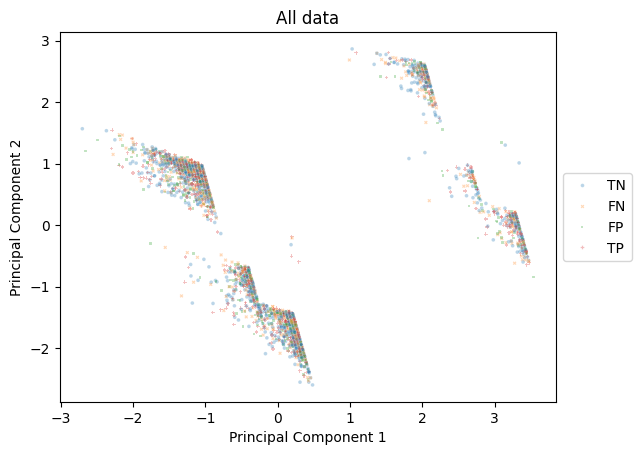

In [200]:
pca_plot(data_all, title="All data", hue='Error_Type', s=7)

Explained Variance Ratio: PC1 = 0.22, PC2 = 0.17


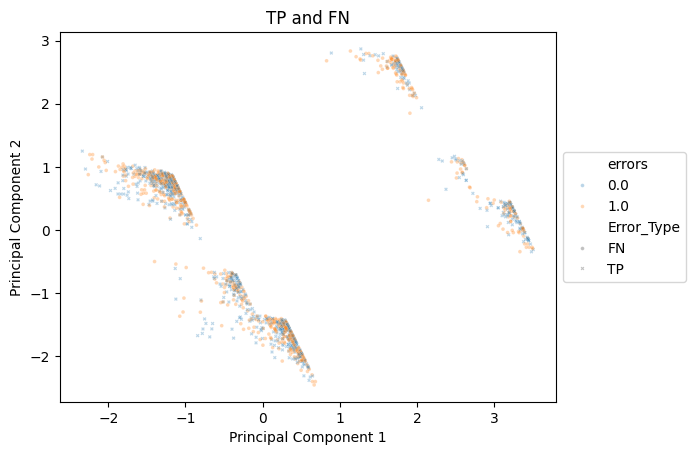

In [201]:
pca_plot(data_tp_fn, title="TP and FN", hue='errors', s=7)

Explained Variance Ratio: PC1 = 0.21, PC2 = 0.18


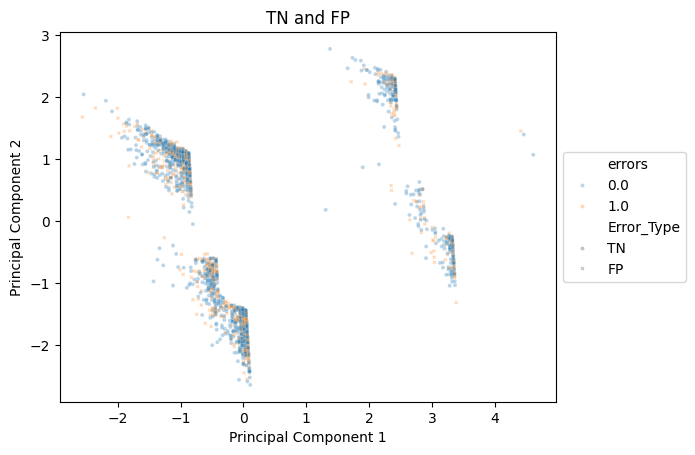

In [197]:
pca_plot(data_tn_fp, title="TN and FP", hue='errors', s=8)

In [103]:
data_now = data_tp_fn

# Determining the epsilon parameter using the K-Distance plot

Using the k-distance plot to determine epsilon by identifying the knee point (where there is a significant increese

32

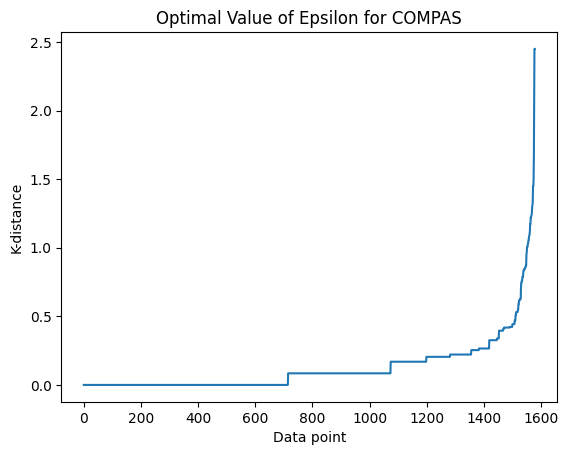

In [73]:
nn_features = data_now.iloc[:, : 11]

neigh = NearestNeighbors(n_neighbors = 3) # compute distance to 2nd nearest neighbor (k=3) for each data point
nbrs = neigh.fit(nn_features)
distances, indices = nbrs.kneighbors(nn_features)

distances = np.sort(distances, axis= 0)
distances = distances [:,1]
plt.plot(distances)
plt.xlabel('Data point')
plt.ylabel('K-distance')
plt.title("Optimal Value of Epsilon for COMPAS")

round(0.02 * len(data_now)) #decide on min nr points for dbscan?

#DBSCAN clustering

Explained Variance Ratio: PC1 = 0.14, PC2 = 0.11


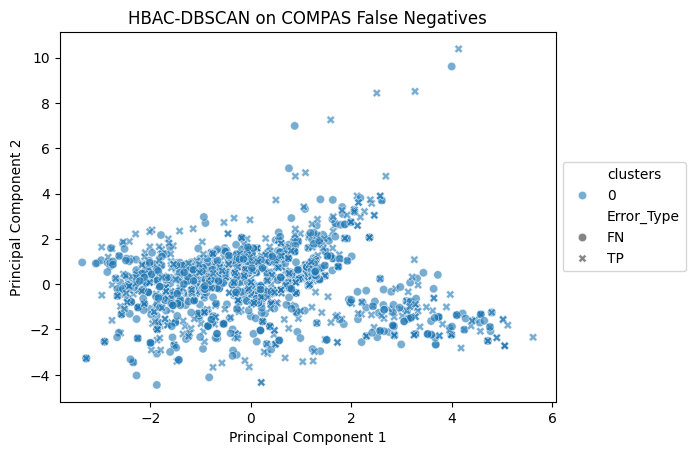

This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
MAX_ITER
0.5250158328055732
[]


In [ ]:
'''False Negatives'''

def bias_with_error_rate_FN(data = TP_FN_data, input_columns = features, error_column = 'FN', max_iter=30, min_splittable_cluster_size = 3, min_acceptable_cluster_size = 3,
                         eps = 0.5, min_samples = 3, x = 0, initial_bias = 0, plot_func = pca_plot):

    # Initialize the dataset
    data = initialize_dataset(data)
    variance_list = []
    acc = accuracy_error(data, error = 'FN') #Calculating accuracy based on FN error
    plot_func(data,'HBAC-DBSCAN on COMPAS False Negatives', 0.6)

    #Loop for clustering iterations
    for i in range(1, max_iter):
        print('This is the current cluster: ', x) #for each iteration the current cluster is printed
        eps = eps - 0.001 #the eps value is incrementedly decreased to identify dense areas
        if len(data['clusters'].unique()) != 1:
            variance_list.append(calculate_variance(data)) #variance calculation is performed if the nr of unique clusters is not equal to 1

        data['new_clusters'] = -2
        candidate_cluster = data.loc[data['clusters'] == x]

        if len(candidate_cluster) < min_splittable_cluster_size:
            x = get_random_cluster(data['clusters'])
            continue

       #apply DBSCAN
        candidate_cluster['new_cluster'] = pd.DataFrame(
            DBSCAN(eps=eps, min_samples=min_samples).fit_predict(
                candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors', 'TP',
                                        'TN', 'FN', 'FP', 'Error_Type',
                                        #'Shap_age', 'Shap_priors_count', 'Shap_sex_Female',
                                        #'Shap_sex_Male', 'Shap_race_African-American', 'Shap_race_Asian',
                                        #'Shap_race_Caucasian', 'Shap_race_Hispanic', 'Shap_race_Native American',
                                        #'Shap_race_Other'
                                        ], axis=1)), index=candidate_cluster.index)

        data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(data['new_clusters'])

        if (len(data['new_clusters'].unique()) <= 2): # Check if a new cluster is found
            continue

        max_bias = get_max_bias(data, bias_type = 'negative')
        min_cluster_size = min_split_cluster_size(data)
        print('smallest cluster: ', min_cluster_size)

        if (max_bias <= initial_bias) & (min_cluster_size > min_acceptable_cluster_size):
            # Add new cluster
            n_cluster = max(data['clusters'])
            first = True
            dif = 1
            for clstr in data['new_clusters'].unique():
                if (clstr == -1):
                    data['clusters'][data['new_clusters'] == clstr] = -1
                elif (clstr == -2):
                    continue
                elif first:
                    data['clusters'][data['new_clusters'] == clstr] = x
                    first = False
                else:
                    data['clusters'][data['new_clusters'] == clstr] =  n_cluster + dif
                    dif += 1

            pca_plot(data,'HBAC-DBSCAN on COMPAS False Negatives', 0.6) # Change this for TN FP data
            #tsne_plot(data, "t-SNE Plot for False Negatives", perplexity=30, learning_rate=200, n_iter=1000, alpha=0.5)
            x = select_new_cluster(data, error_column = 'FN')
            initial_bias = max_bias
        else:
            x = get_random_cluster(data['clusters'])

    print('MAX_ITER')
    print(acc)
    print(variance_list)

bias_with_error_rate_FN()
plt.show()


39

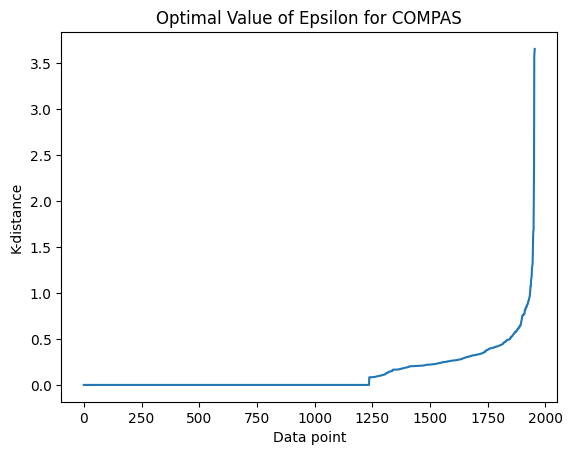

In [ ]:
nn_features = TN_FP_data.iloc[:, : 11]

neigh = NearestNeighbors(n_neighbors = 3) # compute distance to 2nd nearest neighbor (k=3) for each data point
nbrs = neigh.fit(nn_features)
distances, indices = nbrs.kneighbors(nn_features)

distances = np.sort(distances, axis= 0)
distances = distances [:,1]
plt.plot(distances)
plt.xlabel('Data point')
plt.ylabel('K-distance')
plt.title("Optimal Value of Epsilon for COMPAS")

round(0.02 * len(TN_FP_data)) #decide on min nr points for dbscan?

Explained Variance Ratio: PC1 = 0.15, PC2 = 0.12


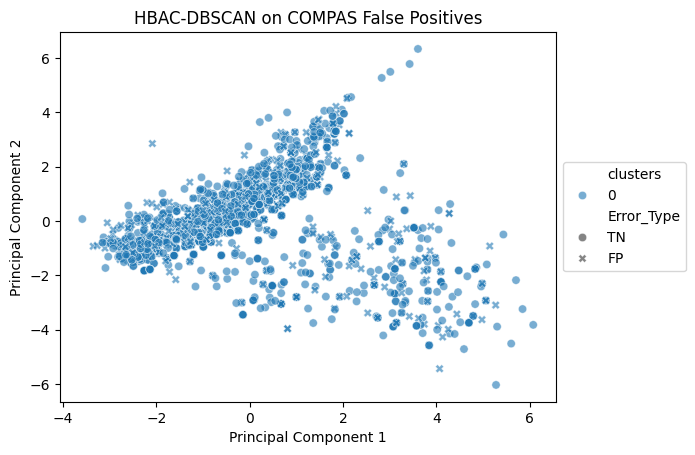

This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is the current cluster:  0
This is 

In [ ]:
'''False Positives   '''

def bias_with_error_rate_FP(data = TN_FP_data,input_columns = features, error_column = 'FP', max_iter=150, min_splittable_cluster_size = 3, min_acceptable_cluster_size = 3,
                         eps = 0.5, min_samples = 3, x = 0, initial_bias = 0, plot_func = pca_plot):

    data = initialize_dataset(data)
    variance_list = []
    acc = accuracy_error(TN_FP_data, error = 'FP')
    plot_func(data,'HBAC-DBSCAN on COMPAS False Positives', 0.6)

    for i in range(1, max_iter):
        #print('Iteration:', i)
        print('This is the current cluster: ', x)
        eps = eps - 0.001 #the eps value is incrementedly decreased to identify dense areas

        if len(data['clusters'].unique()) != 1:
            variance_list.append(calculate_variance(data))

        data['new_clusters'] = -2
        candidate_cluster = data.loc[data['clusters'] == x]

        if len(candidate_cluster) < min_splittable_cluster_size:
            x = get_random_cluster(data['clusters'])
            print('Selected a random cluster:', x)
            continue

        candidate_cluster['new_cluster'] = pd.DataFrame(
            DBSCAN(eps=eps, min_samples=min_samples).fit_predict(
                candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors', 'TP',
                                        'TN', 'FN', 'FP', 'Error_Type',
                                        #'Shap_age', 'Shap_priors_count', 'Shap_sex_Female',
                                        #'Shap_sex_Male', 'Shap_race_African-American', 'Shap_race_Asian',
                                        #'Shap_race_Caucasian', 'Shap_race_Hispanic', 'Shap_race_Native American',
                                        #'Shap_race_Other'
                                        ], axis=1)), index=candidate_cluster.index)
        data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(data['new_clusters'])

        if (len(data['new_clusters'].unique()) <= 2):
            continue

        max_bias = get_max_bias(data, bias_type = 'negative')
        min_cluster_size = min_split_cluster_size(data)
        print('Smallest cluster size:', min_cluster_size)

        if (max_bias <= initial_bias) & (min_cluster_size > min_acceptable_cluster_size):
            n_cluster = max(data['clusters'])
            first = True
            dif = 1
            for clstr in data['new_clusters'].unique():
                if (clstr == -1):
                    data['clusters'][data['new_clusters'] == clstr] = -1
                elif (clstr == -2):
                    continue
                elif first:
                    data['clusters'][data['new_clusters'] == clstr] = x
                    first = False
                else:
                    data['clusters'][data['new_clusters'] == clstr] =  n_cluster + dif
                    dif += 1

            print('Adding new clusters...')
            pca_plot(data,'HBAC-DBSCAN on COMPAS False Positives', 0.6)
            x = select_new_cluster(data, error_column = 'FP')
            initial_bias = max_bias
        else:
            x = get_random_cluster(data['clusters'])

    print('MAX_ITER')
    print(acc)
    print(variance_list)

bias_with_error_rate_FP()
plt.show()

# OPTICS

In [ ]:
TN_FP_data.head()

,age,priors_count,sex_Female,sex_Male,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,...,predicted_class,true_class,errors,TP,TN,FN,FP,Error_Type,clusters,new_clusters
0,-0.778253,-0.108001,-0.491994,0.491994,1.003587,-0.068006,-0.721261,-0.325222,-0.045279,-0.246517,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,TN,0,-1
3,-0.778253,0.705649,-0.491994,0.491994,-0.996426,-0.068006,1.386460,-0.325222,-0.045279,-0.246517,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,FP,0,-1
4,-0.033198,-0.718239,2.032544,-2.032544,-0.996426,-0.068006,-0.721261,3.074824,-0.045279,-0.246517,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,FP,0,-1
7,1.374127,-0.718239,2.032544,-2.032544,-0.996426,-0.068006,-0.721261,-0.325222,-0.045279,4.056520,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,FP,0,-1
8,-1.274956,-0.718239,-0.491994,0.491994,1.003587,-0.068006,-0.721261,-0.325222,-0.045279,-0.246517,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,TN,0,-1


In [ ]:
from sklearn.cluster import OPTICS


#Identifying highest biased cluster

In [ ]:
c = get_cluster_max_bias(TN_FP_data)
highest_biased_cluster = TN_FP_data[TN_FP_data['clusters'] == c]
len(highest_biased_cluster)

accuracy_tnfp = accuracy_error(TN_FP_data)
most_bias_cluster_kmeans_aware = bias_w_error(TN_FP_data, c, 'clusters')
TN_FP_data[TN_FP_data['clusters']==c]


print(f"Cluster {c} General accuracy of classifier on this dataset:", accuracy_tnfp)
print(f"Cluster {c} has the highest discrimination bias ")
print(most_bias_cluster_kmeans_aware)

This cluster is the entire dataset. Cluster: 0


KeyError: None

In [ ]:
c = get_cluster_max_bias(TP_FN_data)
highest_biased_cluster = TP_FN_data[TP_FN_data['clusters'] == c]
len(highest_biased_cluster)

accuracy_tnfp = accuracy_error(TP_FN_data)
most_bias_cluster_kmeans_aware = bias_w_error(TP_FN_data, c, 'clusters')
TP_FN_data[TP_FN_data['clusters']==c]


print(f"Cluster {c} General accuracy of classifier on this dataset:", accuracy_tnfp)
print(f"Cluster {c} has the highest discrimination bias ")
print(most_bias_cluster_kmeans_aware)

In [ ]:
''' Function to decide on min_samples for clustering. If three rows have the same values then min_samples ...

def calculate_min_samples(data, columns):
  min_samples = len(columns)

  for idx, row in data.iterrows():
    similar_rows = data[(data[columns] == row[columns]).all(axis=1)]
    if data[i.values] equals data[j.values] equals data[k.values]
    min_samp = 3
    else if


'''